In [207]:
import numpy as np
import pandas as pd
import yaml
from matplotlib import pyplot as plt
import os

experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/hsa_wood_1300g/2024-05-22_1716338090'
# experiment_folder = '/home/joseph/workspaces/hsa_hopper/hsa_hopper_control/data/no_hsa_wood_1300g/2024-05-15_1715733932'
with open(os.path.join(experiment_folder, 'experiment_config.yaml'), 'r') as f:
    experiment_config = yaml.load(f,yaml.Loader)
with open(os.path.join(experiment_folder, 'hardware_config.yaml'), 'r') as f:
    hardware_config = yaml.load(f,yaml.Loader)

# read tabular data
hop_files_relpath = [relpath for relpath in os.listdir(experiment_folder) if 'hop' in relpath]
hops = len(hop_files_relpath)*[None]
for relpath in hop_files_relpath:
    # hops.append(pd.read_csv(os.path.join(experiment_folder, relpath)))
    parts = os.path.splitext(relpath)
    hop_idx = int((parts[0].split('_'))[-1])
    hops[hop_idx] = pd.read_csv(os.path.join(experiment_folder, relpath))

energy = pd.read_csv(os.path.join(experiment_folder, 'energy.csv'))
ati_measurements = pd.read_csv(os.path.join(experiment_folder, 'ati_measurements.csv'))

[-0.34443219 -0.49109948 -0.54801254 -0.54600407 -0.51838152 -0.4987837
 -0.51775889 -0.52559347 -0.52166279 -0.53502488 -0.56048482 -0.51211691
 -0.5232055  -0.54814434 -0.52643458 -0.54903683 -0.57930022 -0.57486402
 -0.55002149 -0.59265661 -0.584945   -0.56077531 -0.55680045 -0.53686314
 -0.57462784 -0.58595097 -0.56936044 -0.58324094 -0.54214488 -0.56564949
 -0.64755827 -0.56248508 -0.58953571 -0.57330641 -0.59114031 -0.57918995
 -0.5796832  -0.56427409 -0.57539283 -0.59187571 -0.56231187 -0.56496194
 -0.55366884 -0.57031075]
[0.89491121 0.97962417 1.04333484 1.06797498 1.01655678 1.04633207
 1.05352722 1.0838277  1.08046026 1.07944163 1.02984096 1.09461955
 1.07494226 1.02662238 1.05088395 1.0796468  1.05497877 1.08170446
 1.11603744 1.08955984 1.06236742 0.9454363  1.05173155 1.05218087
 1.0390426  1.12043394 1.14063098 0.96932451 1.08535314 1.06235679
 1.06486642 1.06064656 1.1075958  1.07334995 1.13695772 1.09435936
 0.9901721  1.07472735 1.07332599 1.07363948 1.07910457 1.0896

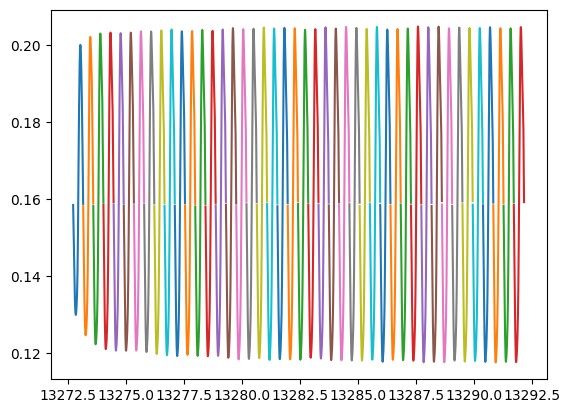

In [208]:
initial_velocity = np.zeros(len(hops))
final_velocity = np.zeros(len(hops))
hop_height = np.zeros(len(hops))
hop_period = np.zeros(len(hops))
for i,hop in enumerate(hops):
    t = hop['t_s'].to_numpy()
    y = hop['y'].to_numpy()
    mode = hop['mode'].to_numpy()
    plt.plot(t,y)
    initial_velocity[i] = (y[1]-y[0])/(t[1]-t[0])
    j = next(j for j, m in enumerate(mode) if m==1)
    final_velocity[i] = (y[j+1]-y[j])/(t[j+1]-t[j])
    hop_height[i] = final_velocity[i]**2 / (2*9.81)
    hop_period[i] = t[-1]-t[0]
print(initial_velocity)
print(final_velocity)
print(hop_height)
print(1/np.average(hop_period))

In [209]:
hop_avg = np.average(hop_height)
hop_std = np.std(hop_height)
print(hop_std)

# filter outliers
# outliers = [i for i,h in enumerate(hop_height) if (h-hop_avg)**2 > (3*hop_std)**2]
outliers = []
# print(outliers)
# outliers = []
hop_height = np.array([h for i, h in enumerate(hop_height) if i not in outliers])
hop_energy = np.array([E for i,E in enumerate(energy.hop_energy.to_numpy()) if i not in outliers])

0.0049364380417592215


In [210]:
# Calculate the height-normalized energy consumption
normalized_energy = np.average(hop_energy)/np.average(hop_height)
# normalized_energy = np.average(hop_energy/hop_height)
print('Energy Consumption:')
print(f'{normalized_energy:.3f} Joules \\ meter')

Energy Consumption:
35.826 Joules \ meter


0.05728322155725258
0.0049364380417592215


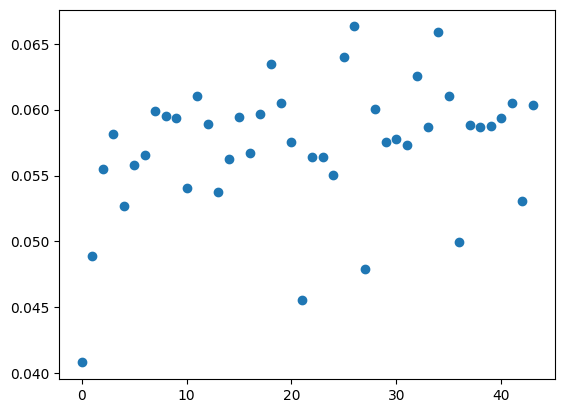

In [211]:
"""
Now that we have indices to liftoff and touchdown, 
we can reorganize the data according to contact mode,
rather than the controller mode (which is how the data was originally saved)
"""
plt.scatter(list(range(len(hop_height))),hop_height)
print(np.average(hop_height))
print(np.std(hop_height))
# plt.scatter(list(range(len(hop_height))),energy.hop_energy/hop_height/100)
# plt.scatter(list(range(len(final_velocity))), final_velocity)

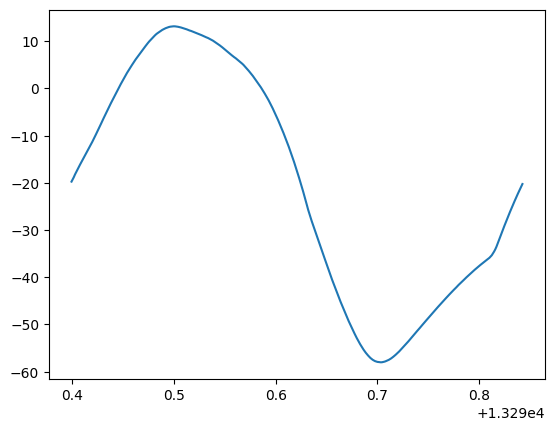

In [212]:
plt.plot(hops[-4]['t_s'],hops[-4]['x_deg'])

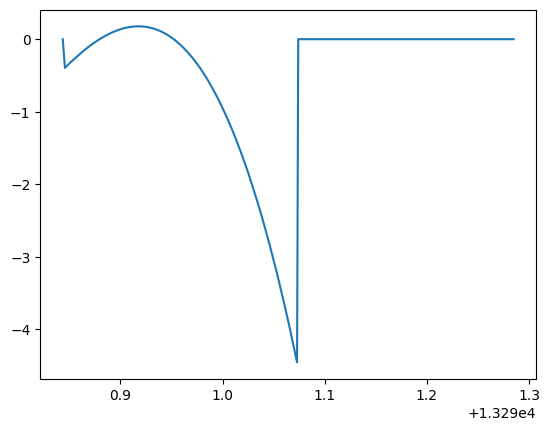

In [213]:
plt.plot(hops[-3]['t_s'],hops[-3]['u_ff'])

In [226]:
R = .095
Kv = 105*(2*np.pi/60)/6
Kt = 1/Kv
print(Kt)
Kx = experiment_config['controller']['kp'][-1]
x0 = experiment_config['controller']['x0'][-1]
print(Kx)

# compute the stance electrical power
power = np.zeros(len(hops))
for i, hop in enumerate(hops):
    indices = hop['mode'] == 2
    x = hop['x_deg'][indices]*np.pi/180
    t = hop['t_s'][indices]
    # x = hop['x_deg']*np.pi/180
    # t = hop['t_s']
    xdot = np.diff(x)/np.diff(t)
    x = x[1:]
    t = t[1:]
    # tau = hop['torque'][indices][:-1]
    # tau = hop['torque'][:-1]
    tau = hop['u_ff'][indices][1:] + Kx*(x0 - x)
    # power[i] = np.trapz(R*(tau/Kt)**2 + tau*xdot, x=t)
    # power[i] = np.trapz(R*(tau/Kt)**2 + np.clip(tau*xdot,0,np.inf), x=t)
    # power[i] = np.trapz(np.clip(R*(tau/Kt)**2 + tau*xdot, 0, np.inf), x=t)
    power[i] = np.trapz(np.abs(R*(tau/Kt)**2 + tau*xdot), x=t)
    

0.5456740906007841
0.0


[1.70434781 0.05728322]
[0.1084638  0.00499351]
0.5722938678204351


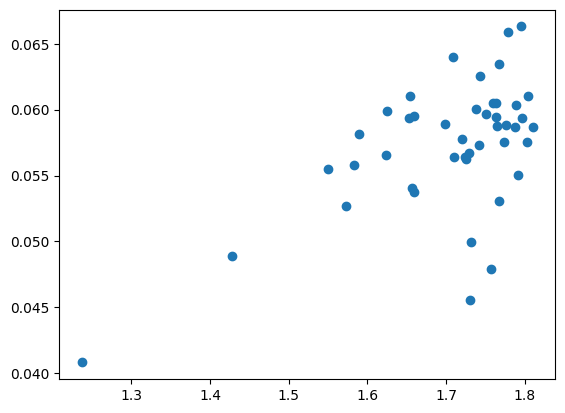

In [227]:
X = power
Y = hop_height
A = np.vstack((X,Y))
mean = A.mean(axis=1)
std = np.sqrt(1/(len(X)-1)*np.sum((A.T-mean)**2, axis=0))
corr = np.sum((X-mean[0])*(Y-mean[1]))/((len(X)-1)*std[0]*std[1])
print(mean)
print(std)
print(corr)
plt.scatter(X,Y)

In [216]:
hop_height.shape

(44,)